In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))  # return the projest's root folder
sys.path.append(project_root)
from utils import multiple_split, load_parameters, split_helper, restrict_group_samples, lgb_optimize

2025-01-29 05:59:54.881031: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 05:59:54.881820: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 05:59:54.885921: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 05:59:54.895067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738126794.910065   16576 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738126794.91

In [2]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import optuna

/root/batteryDT/batteryML/venvSANDIA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load the parameters
params = load_parameters('../parameters.yaml')

# load the model
model_name = 'nasa_3features_first20_01886500.pkl'
with open(f'../model_nasa/{model_name}', 'rb') as file:
    model = pickle.load(file)

# load the test data
test = pd.read_csv('../data_nasa/test_processed_first20.csv',index_col=0)
test_x = test[params.features]
test_y = test[params.labels]

# pruned model save path
pruned_model_path = f'pruned_{model_name.split('.')[0]}/'
os.makedirs(os.path.dirname(pruned_model_path), exist_ok=True)

dataset: nasa
features: ['voltage', 'temperature', 'discharge_voltage_rate']
labels: ['capacity']
data_groupby: ['cycle', 'capacity']
num_trials: 500
overlap_mode: all
split_size: 20
multi_split_size: [5, 10, 15, 20, 40, 50, 70, 100]
num_restricted: 20


In [4]:
def use_tree_subset(model, test_x, test_y, num_trees_subset):
    num_trees_subset = round(num_trees_subset)
    pred_subset = model.predict(test_x, num_iteration=num_trees_subset)
    subset_mae = mean_absolute_error(test_y, pred_subset)

    return subset_mae

In [5]:
pred = model.predict(test_x)
mae = mean_absolute_error(test_y, pred)

number of trees in the best model: 442


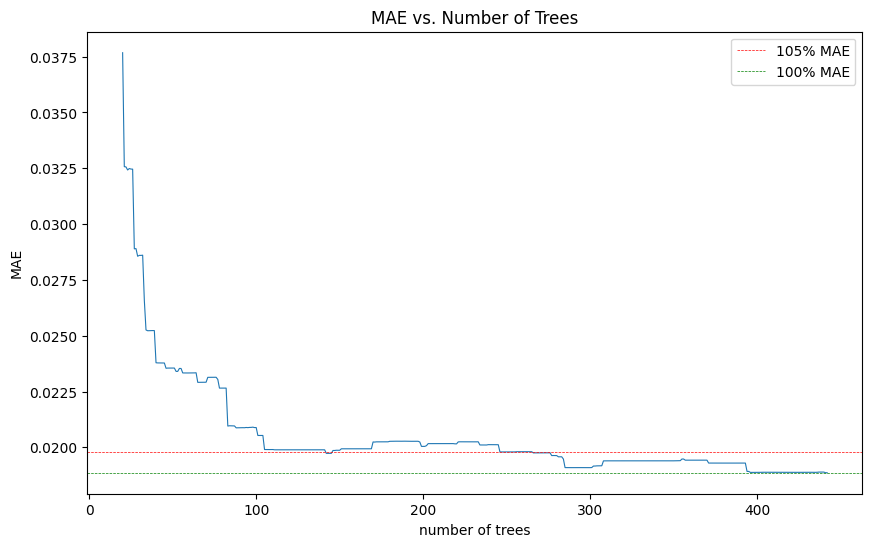

In [6]:
# benchmark the test error with a subset of the trees
num_trees = model.booster_.num_trees()
print(f"number of trees in the best model: {num_trees}")

num_list = list(range(20, num_trees+1))
mae_list = []
for i in num_list:
    subset_mae = use_tree_subset(model, test_x, test_y, i)
    mae_list.append(subset_mae)

plt.figure(figsize=(10,6))
plt.plot(num_list, mae_list, linestyle='-', lw=0.8)
# plt.axhline(y=mae * 0.95, color='red', linestyle='--', lw=0.5, label='95% MAE')
plt.axhline(y=mae * 1.05, color='red', linestyle='--', lw=0.5, label='105% MAE')
plt.axhline(y=mae, color='green', linestyle='--', lw=0.5, label='100% MAE')
plt.xlabel('number of trees')
plt.ylabel('MAE')
plt.title('MAE vs. Number of Trees')
plt.legend()
# plt.grid(True)
plt.show()

In [7]:
def generate_model_subset(model, num_trees):
    # 第1步: 获取Booster对象
    booster = model.booster_

    # 第2步: 只保存前 100 棵树的模型
    booster.save_model('partial_model.txt', num_iteration=num_trees)

    # 第3步: 从文件中加载部分模型 (前100棵树)
    partial_booster = lgb.Booster(model_file='partial_model.txt')

    # 第2步: 使用虚拟数据重新fit
    X_dummy = np.zeros((2, len(partial_booster.feature_name())))  # 虚拟输入数据，形状与原始特征匹配
    y_dummy = np.zeros((2,))  # 一个虚拟的输出

    # 第3步: 通过init_model重新绑定模型
    partial_model_30trees = lgb.LGBMRegressor()
    partial_model_30trees.fit(X_dummy, y_dummy, init_model=partial_booster)  # 重新标记为“已拟合”

    # # 第4步: 重新创建LGBMRegressor，并将Booster与之绑定
    # partial_model_30trees = lgb.LGBMRegressor()
    # partial_model_30trees = partial_model_30trees.load_model('partial_model.txt')
    # # partial_model_30trees._Booster = partial_booster

    # soh_model_30_path = '../model/soh_model_60trees.pickle'
    # with open(soh_model_30_path, 'wb') as file:
    #         pickle.dump(partial_model_30trees, file)

    return partial_model_30trees

In [8]:
# save the model
print(f'-> train, valid data: overlap windows on {params.multi_split_size}')
print(f'-> test data: use the first {params.num_restricted} samples in each discharge cycle')
print(f'--> MAE with full trees: {mae}')
print('----------------------------------------------------------------------------')
num_trees_list = [110,200,300]
for i in num_trees_list:
    subset_mae = use_tree_subset(model, test_x, test_y, i)
    print(f'MAE with {i} trees: {subset_mae}')
    
    # new_model = generate_model_subset(model, i)
    # new_pred = new_model.predict(test_x)
    # new_mae = mean_absolute_error(test_y, new_pred)
    # print(f'MAE on new model: {new_mae}')

    # with open(f'{pruned_model_path}pruned_{i}trees_{str(f"{subset_mae:.4f}".split(".")[1])}.pkl', 'wb') as f:
    #     pickle.dump(new_model, f)
    print(f'already saved into {model_name}')

-> train, valid data: overlap windows on [5, 10, 15, 20, 40, 50, 70, 100]
-> test data: use the first 20 samples in each discharge cycle
--> MAE with full trees: 0.01886499629823821
----------------------------------------------------------------------------
MAE with 110 trees: 0.01990305905559436
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] lambda_l1 is set=0.0322162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0322162
[LightGBM] [Warning] feature_fraction is set=0.907732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.907732
[LightGBM] [Warning] bin_construct_sample_cnt is set=200000, subsample_for_bin=200000 will be ignored. Current value: bin_construct_sample_cnt=200000
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 wi

/root/batteryDT/batteryML/venvSANDIA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/batteryDT/batteryML/venvSANDIA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/batteryDT/batteryML/venvSANDIA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
